#Pop Time vs Ball Velocity Analysis

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
file_list <- list.files(pattern = "^game_events.*\\.csv$") # read in files
print(file_list)

 [1] "game_events-1900_01_TeamKJ_TeamB.csv" 
 [2] "game_events-1900_02_TeamKJ_TeamB.csv" 
 [3] "game_events-1900_03_TeamKJ_TeamB.csv" 
 [4] "game_events-1900_04_TeamKK_TeamB.csv" 
 [5] "game_events-1900_05_TeamKK_TeamB.csv" 
 [6] "game_events-1900_06_TeamKL_TeamB.csv" 
 [7] "game_events-1900_07_TeamKL_TeamB.csv" 
 [8] "game_events-1900_08_TeamKL_TeamB.csv" 
 [9] "game_events-1900_09_TeamKK_TeamB.csv" 
[10] "game_events-1901_01_TeamLG_TeamA3.csv"
[11] "game_events-1901_02_TeamLG_TeamA3.csv"
[12] "game_events-1901_03_TeamLG_TeamA3.csv"
[13] "game_events-1901_04_TeamLI_TeamA3.csv"
[14] "game_events-1901_05_TeamLI_TeamA3.csv"
[15] "game_events-1901_06_TeamLI_TeamA3.csv"
[16] "game_events-1901_07_TeamLK_TeamB.csv" 
[17] "game_events-1901_08_TeamLK_TeamB.csv" 
[18] "game_events-1901_09_TeamLK_TeamB.csv" 
[19] "game_events-1901_10_TeamLJ_TeamB.csv" 
[20] "game_events-1901_11_TeamLJ_TeamB.csv" 
[21] "game_events-1901_12_TeamLJ_TeamB.csv" 
[22] "game_events-1901_13_TeamLL_TeamB.csv" 
[23] "game

In [3]:
combined_event_data <- data.frame()

In [4]:
game_id <- 1
for (file in file_list) {
  event_data <- read_csv(paste0("/content/", file))
  event_data <- event_data %>%
    mutate(game_id = game_id) # Add game_id column with unique value
  combined_event_data <- bind_rows(combined_event_data, event_data)
  game_id <- game_id + 1 # Increment game_id counter
}

New names:
• `` -> `...1`
Rows: 939 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): game_str
dbl (6): ...1, play_id, play_per_game, timestamp, player_position, event_code
lgl (1): at_bat

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 964 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): game_str
dbl (6): ...1, play_id, play_per_game, timestamp, player_position, event_code
lgl (1): at_bat

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 742 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): game_str
dbl (6): ...1, play

In [5]:
#we want to find plays where the catcher throws to 2B right after a pitch (to simulate a play with a stolen base attempt)
find_stolen_base_plays <- function(event_data, infielder) {
  result <- event_data %>% select(game_str, game_id, play_id, timestamp, player_position, event_code) %>% #selecting only the columns needed
  group_by(game_id, play_id) %>% #each scenario will be a different play
    filter(n() > 3) %>% #n() > 3 means the standard pitch, miss, catch (or nothing eventful happens) is eliminated
      filter((player_position == 2 & event_code == 2) |
              (player_position == 2 & event_code == 3) | #catcher throws ball
              (player_position == infielder & event_code == 2)) %>% #2B catches the ball
       group_by(game_id, play_id) %>%
        filter(all(c(any(player_position == 2 & event_code == 2),
                any(player_position == 2 & event_code == 3), #ensures only (2,3) row and (infielder,2) row exists for a play
               any(player_position == infielder & event_code == 2))))
  return(result)
}
# gather the stolen base sequences for both 2B and SS
pop_time_main_2b <- find_stolen_base_plays(combined_event_data, 4)
pop_time_main_ss <- find_stolen_base_plays(combined_event_data, 6)

# calculate the pop time for both 2B and SS sequences
pop_time_2b <- pop_time_main_2b %>% group_by(game_id, play_id) %>%
         mutate(pop_time =
         (timestamp[player_position == 2 & event_code == 3] -
         timestamp[player_position == 2 & event_code == 2])*.001)


pop_time_ss <- pop_time_main_ss %>% group_by(game_id, play_id) %>%
         mutate(pop_time =
         (timestamp[player_position == 2 & event_code == 3] -
         timestamp[player_position == 2 & event_code == 2])*.001)



In [6]:
# combine the results into 1 table
pop_time_combined <- bind_rows(pop_time_2b, pop_time_ss) %>% arrange(game_id, play_id)
pop_time_combined <- subset(pop_time_combined,player_position == 6 | player_position == 4)


In [7]:
# write the csv file
install.packages("googledrive")
library(googledrive)
write.csv(pop_time_combined, file = "pop_time_combined.csv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,X,...1,game_str,play_per_game,success,play_id,...6,game_id,timestamp,player_position,event_code,pop_time,velocity_m_per_s
,<int>,<int>,<chr>,<int>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,1,1902_08_TeamMJ_TeamB,80,FALSE,80,39,35,2887744,4,2,0.650,31.59239
4,4,4,1902_08_TeamMJ_TeamB,222,FALSE,222,43,35,8463344,4,2,0.700,31.48230
5,5,5,1902_09_TeamMJ_TeamB,296,FALSE,296,45,36,11093955,4,2,0.800,32.12095
6,6,6,1902_12_TeamMI_TeamA3,61,TRUE,61,49,39,1944654,4,2,0.700,32.19064
7,7,7,1902_23_TeamMA_TeamA1,99,FALSE,99,65,52,3242588,4,2,0.800,32.67431
8,8,8,1902_24_TeamMA_TeamA1,34,FALSE,34,67,53,925643,4,2,0.693,32.52840
9,9,9,1902_31_TeamMF_TeamA2,101,FALSE,101,81,61,2898396,4,2,0.550,29.17044
10,10,10,1903_01_TeamNE_TeamA2,260,FALSE,259,83,62,8545286,4,2,0.561,34.66795
11,11,11,1903_01_TeamNE_TeamA2,285,FALSE,284,84,62,9427509,4,2,0.627,34.42798


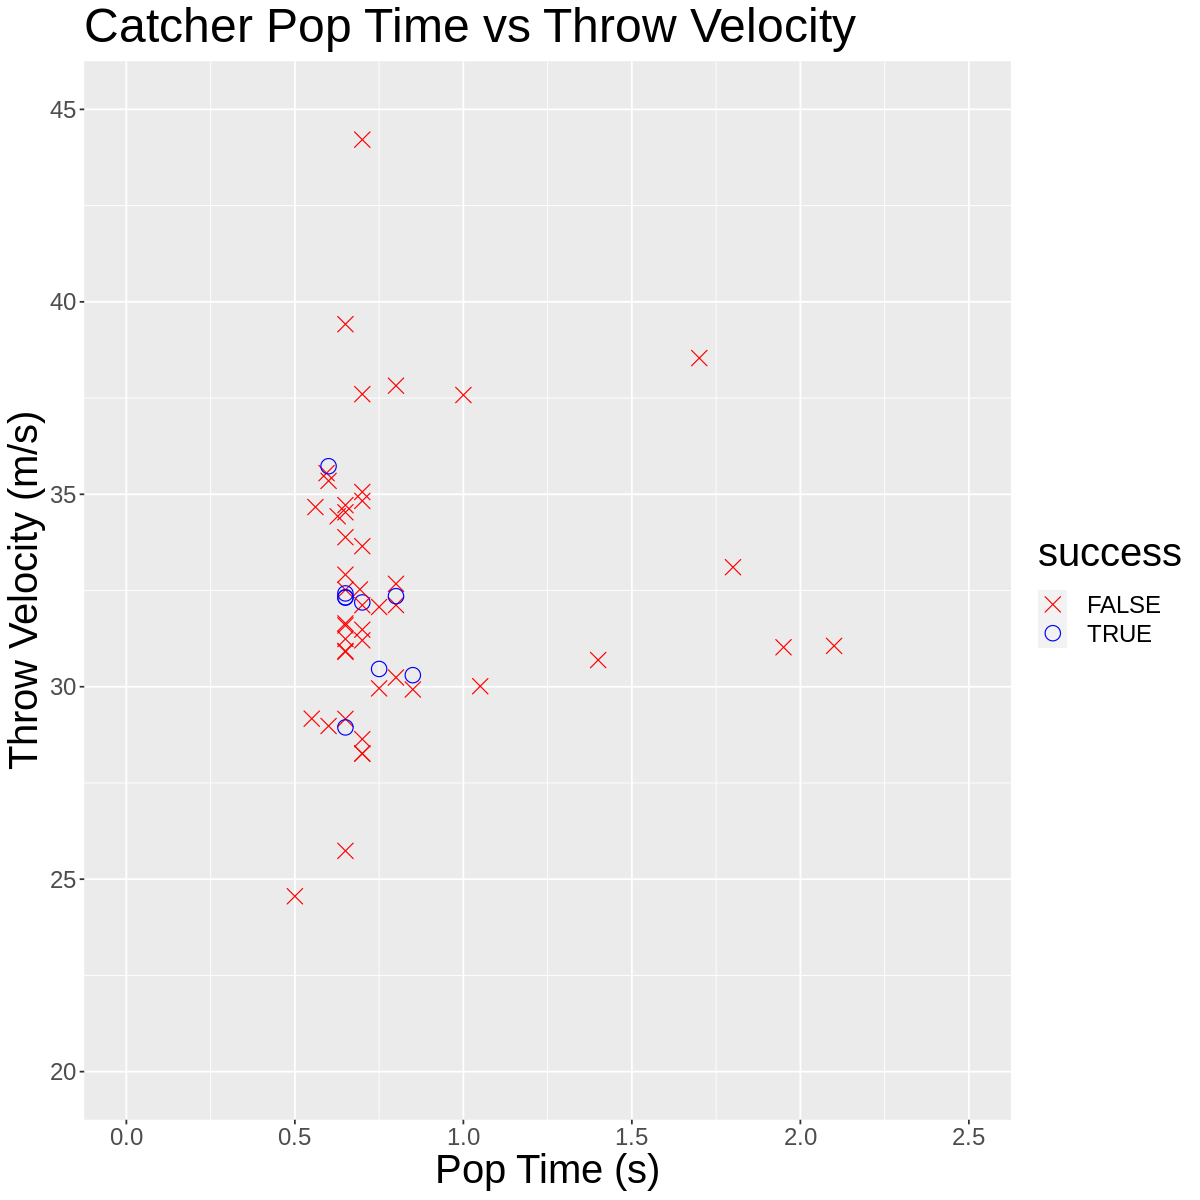

In [10]:
# make scatter plot
df <- read.csv('pop_time_with_success_and_velocity.csv')

clean_df <- df %>%
    na.omit() %>% #remove rows with missing (NA) values
      mutate(success = as.logical(success)) #changes 0 and 1 to boolean
clean_df
options(repr.plot.width = 10, repr.plot.height = 10) #size of graph
pop_velocity_plot <- ggplot(clean_df, aes(x = pop_time, y = velocity_m_per_s, shape = success, color = success))+
    geom_point(size = 4) +
    lims(x = c(0, 2.5), y = c(20, 45)) + #sets min and max x and y range
    scale_shape_manual(values = c(4, 1)) + # 1: Hollow Circle (FALSE), 4: Cross (TRUE)
    scale_color_manual(values = c("red", "blue")) +
    scale_fill_discrete(labels=c("Safe", "Out")) +
        labs(
          title = "Catcher Pop Time vs Throw Velocity",
          x = "Pop Time (s)",
          y = "Throw Velocity (m/s)"
        ) +
        theme(
          text = element_text(size = 18),
          title = element_text(size = 24)
        )

print(pop_velocity_plot)
#ggsave("Pop_Time_vs_Throw_Velocity.tiff", pop_velocity_plot, width=10, height=10, units="in", dpi=300)